<a href="https://colab.research.google.com/github/LuanPCunha/TCC/blob/main/Copy_CNN_Rafa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloads e imports

In [1]:
# !pip install tensorflow
# !pip install keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sklearn
import numpy as np
import pandas as pd
from numpy import loadtxt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import layers
from keras.layers import Dropout, Conv1D, MaxPooling1D, Flatten, Dense, SpatialDropout1D, BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import schedules, Adam, Adadelta, SGD, RMSprop, Adagrad, Adamax, Nadam, Ftrl # Estamos usando só o Nadam
from keras.models import Sequential
from keras.layers.embeddings import Embedding


from numpy.random import seed  
tf.random.set_seed(2)

In [4]:
def tokenize(tweets_list):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(tweets_list)
    return tokenizer.texts_to_sequences(tweets_list), tokenizer

In [5]:
def pad(text_tokenized, length=None):
    return pad_sequences(text_tokenized, maxlen=length, padding='post')

In [6]:
def preprocess(tweets_list, max_text_length):
    print(max_text_length)
    preprocess_tweets_list, tweets_list_tokenizer = tokenize(tweets_list)

    preprocess_tweets_list = pad(preprocess_tweets_list, length=max_text_length)

    return preprocess_tweets_list, tweets_list_tokenizer

In [7]:
def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [8]:
# Plot de Gráficos

def plot_accuracy(history, miny=None):
  loss, accuracy, val_loss, val_accuracy = list(history.history.keys())
  print(accuracy,val_accuracy,loss,val_loss)
  acc = history.history[accuracy]
  test_acc = history.history[val_accuracy]
  epochs = range(len(acc))
  plt.plot(epochs, acc)
  plt.plot(epochs, test_acc)
  if miny:
    plt.ylim(miny, 1.0)
  plt.legend(['train', 'test'], loc='upper left')
  plt.title('accuracy') 
  plt.xlabel('epoch')
  plt.show()
  
  
# def plot_loss(history, miny=None):
  loss = history.history[loss]
  val_loss = history.history[val_loss]
  epochs = range(len(loss))
  plt.plot(epochs, loss)
  plt.plot(epochs, val_loss)
  if miny:
    plt.ylim(miny, 1.0)
  plt.legend(['train', 'test'], loc='upper left')
  plt.title('loss') 
  plt.xlabel('epoch')
  plt.show()

# Carrega base

In [118]:
# Base1 Com StopWords
PATH_BASE1_JUNTO_COM_DA_LEILA_BALANCEADA = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base1JuntaHateENotHateDaLeila_balanceada.csv"
#MATRIZ_CBOW_300_BASE_1 = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base1JuntaHateENotHateDaLeila_balanceada_CBOW300.CSV", delimiter=',')

# Base2 Sem StopWords
PATH_BASE2_LEILA_LIMPISSIMA_BALANCEADA = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base2_maior4_menor25_limpissima_balanceada.csv"
#MATRIZ_CBOW_300_BASE_2_LEILA = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base2_maior4_menor25_limpissima_balanceada_CBOW300.CSV", delimiter=',')

PATH_BASE_1_CLASSIFICADA_BALANCEADA = r"/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base1_classificada_balanceada.csv" #entrada

PATH_BASE_2_CLASSIFICADA_BALANCEADA = r"/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base2_classificada_balanceada.csv" #entrada
# MATRIZ_CBOW_300_BASE_2 = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base2_classificada_balanceada_CBOW300.csv", delimiter=',') #saida

# Execução modelo

In [120]:
tweets = pd.read_csv(PATH_BASE_1_CLASSIFICADA_BALANCEADA, index_col=0)
text_column = tweets['text']
text_column

0        retwet a bahia em vai fazer anos sendo governa...
1        k imagine se fosse atitude mental negativa se ...
2        o general heleno é que nem o bolsonaro rosna m...
3        alan tem que ser muito cara de pau achar que e...
4        os canalhascomunistas caçarão a chapa presiden...
                               ...                        
11145    nosso egoísmo é em grande parte produto da soc...
11146    abençoado ano novo sua linda e querida obrigad...
11147          leva eles com a gente eles são amorzinhos d
11148    se tu nunca fumou maconha cole isso no seu mur...
11149                            k k ata eu sou meia sonsa
Name: text, Length: 11150, dtype: object

In [121]:
# Pega a média de caracteres dos tweets de toda a base
max_text_length = int(text_column.apply(lambda x: len(str(x).split(' '))).max())
max_text_length

61

In [122]:
output_label = tweets['label']
print(output_label)
print(type(output_label))
input_data, text_tokenizer = preprocess(text_column, None)
    
text_vocab_size = len(text_tokenizer.word_index)
print("Vocabulary size:", text_vocab_size)

0        1
1        1
2        1
3        1
4        1
        ..
11145    0
11146    0
11147    0
11148    0
11149    0
Name: label, Length: 11150, dtype: int64
<class 'pandas.core.series.Series'>
None
Vocabulary size: 19030


In [123]:
x_train, x_test, y_train, y_test = train_test_split(input_data, output_label, test_size=0.2, random_state=19)

In [124]:
x_train.shape

(8920, 61)

In [125]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(55,)),  # input layer (1)
    keras.layers.Dense(128, activation='relu'),  # hidden layer (2)
    keras.layers.Dense(1, activation='sigmoid') # output layer (3)
])

In [126]:
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [127]:
model.fit(x_train, y_train, epochs=20)  # we pass the data, labels and epochs and watch the magic!

Epoch 1/20


ValueError: ignored

In [ ]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=1) 

print('Test accuracy:', test_acc)

67/67 [==============================] - 0s 2ms/step - loss: 12.5913 - accuracy: 0.5357
Test accuracy: 0.5356974005699158

In [ ]:
predictions = model.predict(x_test)

In [ ]:
predictions[0]

In [ ]:
np.argmax(predictions[0])

In [ ]:
y_array = list(y_test)
y_array[2]

In [ ]:
x_test

In [147]:
# parametros:
BATCH_SIZE = 3
EPOCHS = 6
VAL_AND_TST_SIZE = 0.2
LEARN_RATE = 0.00005
# ******
BETA_1 = 0.09
BETA_2 = 0.0999
EPSILON = 1e-07
# *****
EMBEDDING_DIMENSION = 300  
MAX_TEXT_SIZE = max_text_length 
VOCAB_SIZE = text_vocab_size

In [163]:
def optimize (learning_rate, beta_1, beta_2, epsilon):
  
  return Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, name="Nadam")

In [164]:
# https://towardsdatascience.com/visualizing-how-filters-work-in-convolutional-neural-networks-cnns-7383bd84ad2c
# https://colab.research.google.com/drive/18ejmbJn9KVcqWJzOvAz84HxIpPMeTijU#scrollTo=Hjf_s9MrZky2

# https://stackoverflow.com/questions/67848962/selecting-loss-and-metrics-for-tensorflow-model ##GOD
#https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/

In [165]:
def create_cnn (vocab_size, embedding_dimen, max_text_size ):

  # embedding_layer = Embedding(VOCAB_SIZE, EMBEDDING_DIMENSION, input_length=MAX_TEXT_SIZE)

  # int_sequences_input = keras.Input(shape=(None,), dtype="int64")
  # embedded_sequences = embedding_layer(int_sequences_input)
  # x = layers.Conv1D(300,3, activation="relu")(embedded_sequences)
  # # ******
  # x = layers.Dense(300, activation="relu")(x)
  # x = layers.Dropout(0.1)(x)
 
  # x = layers.GlobalMaxPooling1D()(x)
  # # x = layers.MaxPooling1D()(x)
  # # x = layers.Conv1D(100, 3, activation="relu")(x)
  # # x = layers.MaxPooling1D()(x)
  # # x = layers.Conv1D(100, 3, activation="relu")(x)
  # # x = SpatialDropout1D(0.1)(x)
  # # x = BatchNormalization()(x)
  # # model.add(Flatten())
  # # *******
  # preds = layers.Dense(2, activation='sigmoid')(x)
  # modelo = keras.Model(int_sequences_input, preds)


  modelo = keras.Sequential([
    keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIMENSION, input_length=MAX_TEXT_SIZE),                         
    keras.layers.Conv1D(10,3, activation="relu"),
    keras.layers.Flatten(input_shape=(61,)),  # input layer (1)
    keras.layers.Dense(61, activation='relu'),  # hidden layer (2)
    keras.layers.Dropout(0.1),
    keras.layers.Dense(2, activation='sigmoid') # output layer (3)
    ])
  
  return modelo 
  

In [166]:
def train_model(input_data, output_label, embedding_dimen, batch_size, epochs, validation_and_test_size):
    
    x_train, x_test, y_train, y_test = train_test_split(input_data, output_label, test_size=validation_and_test_size, random_state=42)

    optimizer = optimize(LEARN_RATE, BETA_1, BETA_2, EPSILON)
    
    model = create_cnn(VOCAB_SIZE, EMBEDDING_DIMENSION, MAX_TEXT_SIZE)
    model.summary()
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=optimizer, metrics=['accuracy'])                                                                                                
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split = validation_and_test_size, verbose=2, use_multiprocessing=True)
    scores = model.evaluate(x_test, y_test, verbose=1)
    
    return history, model, x_test, y_test

In [167]:
# plot dos gráficos
history, model1, x_test, y_test = train_model(input_data, output_label, EMBEDDING_DIMENSION, BATCH_SIZE, EPOCHS, VAL_AND_TST_SIZE)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 61, 300)           5709000   
                                                                 
 conv1d_12 (Conv1D)          (None, 59, 10)            9010      
                                                                 
 flatten_23 (Flatten)        (None, 590)               0         
                                                                 
 dense_50 (Dense)            (None, 61)                36051     
                                                                 
 dropout_12 (Dropout)        (None, 61)                0         
                                                                 
 dense_51 (Dense)            (None, 2)                 124       
                                                                 
Total params: 5,754,185
Trainable params: 5,754,185
N

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


2379/2379 - 14s - loss: 0.6657 - accuracy: 0.6104 - val_loss: 0.6764 - val_accuracy: 0.6076 - 14s/epoch - 6ms/step
Epoch 2/6
2379/2379 - 13s - loss: 0.6545 - accuracy: 0.6239 - val_loss: 0.6788 - val_accuracy: 0.6037 - 13s/epoch - 6ms/step
Epoch 3/6
2379/2379 - 14s - loss: 0.6596 - accuracy: 0.6389 - val_loss: 0.6880 - val_accuracy: 0.6211 - 14s/epoch - 6ms/step
Epoch 4/6
2379/2379 - 14s - loss: 0.6500 - accuracy: 0.6616 - val_loss: 0.6729 - val_accuracy: 0.6435 - 14s/epoch - 6ms/step
Epoch 5/6
2379/2379 - 13s - loss: 0.6026 - accuracy: 0.7056 - val_loss: 0.6521 - val_accuracy: 0.6715 - 13s/epoch - 6ms/step
Epoch 6/6
2379/2379 - 13s - loss: 0.5672 - accuracy: 0.7311 - val_loss: 0.6504 - val_accuracy: 0.6928 - 13s/epoch - 6ms/step
70/70 [==============================] - 0s 2ms/step - loss: 0.6006 - accuracy: 0.7309


In [176]:
list(history.history.keys())
history.history

{'accuracy': [0.6104260087013245,
  0.6238788962364197,
  0.6388733386993408,
  0.6615751385688782,
  0.7055773735046387,
  0.7310818433761597],
 'loss': [0.6657261848449707,
  0.6545185446739197,
  0.6595746278762817,
  0.6500428915023804,
  0.6025585532188416,
  0.5671647787094116],
 'val_accuracy': [0.6076233386993408,
  0.6036995649337769,
  0.621076226234436,
  0.6434977650642395,
  0.6715246438980103,
  0.6928251385688782],
 'val_loss': [0.676389753818512,
  0.6787914633750916,
  0.6880099773406982,
  0.6728626489639282,
  0.6521499156951904,
  0.6504086852073669]}

accuracy val_accuracy loss val_loss


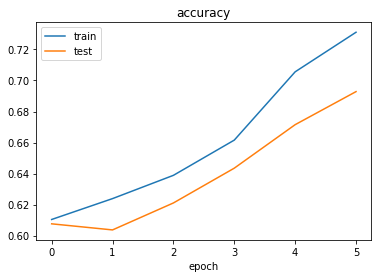

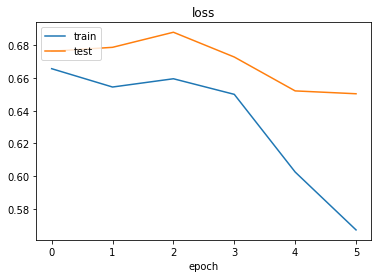

In [177]:
plot_accuracy(history)
# plot_loss(history)

In [170]:
y_prob = model1.predict(x_test) 
print(y_prob)
y_labelpred = y_prob.argmax(axis=-1)
#len(y_prob)
print(y_labelpred)
len(y_labelpred)

[[0.45459083 0.45847073]
 [0.33185753 0.64256245]
 [0.44013593 0.46555147]
 ...
 [0.09621757 0.90116984]
 [0.36499682 0.5860693 ]
 [0.18081608 0.792591  ]]
[1 1 1 ... 1 1 1]


2230

In [171]:
y_labeltrue=y_test
print(y_labeltrue)

9271     0
2874     1
2174     1
1744     1
4192     1
        ..
11138    0
7341     0
5481     1
4412     1
4551     1
Name: label, Length: 2230, dtype: int64


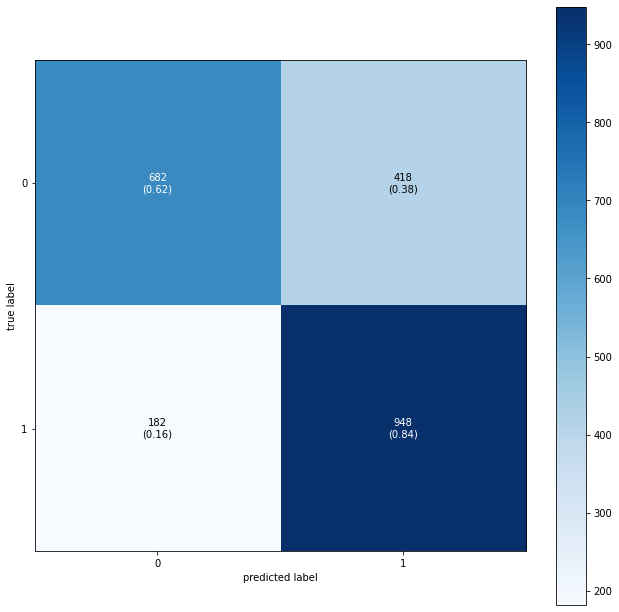

In [172]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

classes = confusion_matrix(y_labeltrue,y_labelpred)

fig,ax = plot_confusion_matrix(figsize=(11, 11),conf_mat=classes,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                #  class_names=["hate","not"],
                              )
plt.show()

In [173]:
# # lr_schedule = schedules.ExponentialDecay(
# #     initial_learning_rate=lr,
# #     decay_steps=10000,
# #     decay_rate=0.9)

# # https://keras.io/api/optimizers/
# # https://keras.io/examples/nlp/pretrained_word_embeddings/
# # https://keras.io/api/layers/base_layer/#layer-class

# # optimizer = Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name="Adadelta") 
# #optimizer = SGD(learning_rate=0.01, momentum=0.0, nesterov=True, name="SGD")
# #optimizer = RMSprop(learning_rate=0.001,rho=0.9,momentum=0.0,epsilon=1e-07,centered=True,name="RMSprop")
# #optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True, name="Adam")
# #optimizer = Adagrad(learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07, name="Adagrad")
# #optimizer = Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")
# optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam") # 96% Embedding Treinado /
# #optimizer = Ftrl(learning_rate=0.001, learning_rate_power=-0.5, initial_accumulator_value=0.1, l1_regularization_strength=0.1, l2_regularization_strength=0.1, l2_shrinkage_regularization_strength=0.001, beta=0.0001, name="Ftrl")

# # # defininindo a camada de embedding utilizando a matriz
# # embedding_layer = Embedding(input_dim=MATRIZ_CBOW_300_BASE_2.shape[0],
# #                             output_dim=MATRIZ_CBOW_300_BASE_2.shape[1],
# #                             # weights=[MATRIZ_CBOW_300_BASE_2],
# #                             embeddings_initializer=keras.initializers.Constant(MATRIZ_CBOW_300_BASE_2),
# #                             input_length=tam_max,
# #                             trainable=False)


# model = Sequential()
# # primeira camada se trata do embedding. 
# # model.add(embedding_layer)
# model.add(Embedding(tam_vocab, embedding_dimen, input_length=tam_max)) 


# # camada convolucional
# # filtros referentes ao output dessa camada,
# # tamanho nucleo = 3, se tratando apenas de uma dimensão (conv1d)
# # padding 'valid' = sem padding
# # função de ativação = relu
# model.add(Dropout(drp))
# model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
# model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
# model.add(Dropout(drp))
# model.add(MaxPooling1D())


# # camada convolucional                         'valid|same'
# model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
# model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
# model.add(Dropout(drp))
# model.add(MaxPooling1D())


# # nivela o output para utilização na camada densa
# model.add(Flatten())

# # regularização por dropout
# model.add(Dense(2, activation='softmax'))


# model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=optimizer, metrics=['accuracy']) 
# model.summary()

# # Fit the model                                                                                               #val split
# history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs,validation_data=(X_test, y_test), validation_split = 0.3, verbose=2)

# # Final evaluation of the model
# scores = model.evaluate(X_test, y_test, verbose=1)

In [174]:
# # plot dos gráficos
# plot_accuracy(history)
# plot_loss(history)

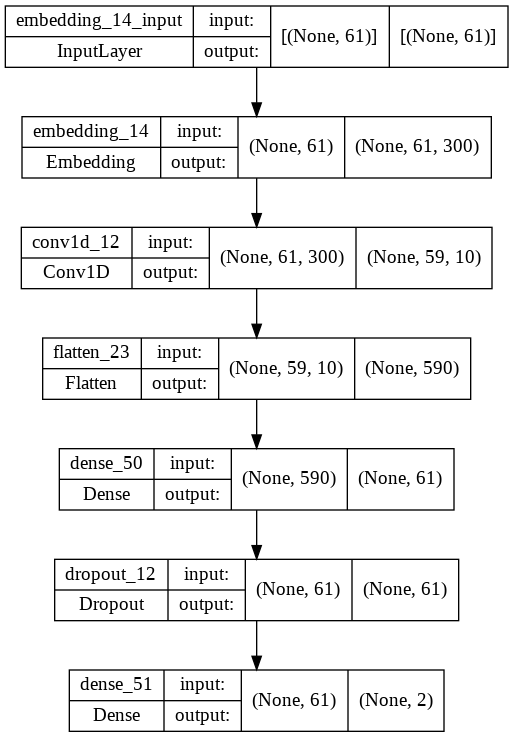

In [175]:
tf.keras.utils.plot_model(model1, to_file='/meuarquivo.png', show_shapes=True)